In [1]:
%load_ext autoreload
%autoreload 2

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from scipy.stats import entropy
import time
import os
import copy
import sys
import gc
sys.path.append('./python_files')

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_models import *

#!pip install Pillow==5.0.0

import numpy as np

data_dir = './data/imagenet/'
class_file = 'class_ids.txt'
TRAIN = 'uniform_training'
VAL = 'uniform_test'
TEST = 'uniform_val'

from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


In [4]:
# VGG-16 Takes 224x224 images as input, so we resize all of them
def load_imagenet(data_dir, batch_size=8, shuffle=True, num_workers=1, pin_memory=True):
    data_transforms = {
        TRAIN: transforms.Compose([
            # Data augmentation is a good practice for the train set
            # Here, we randomly crop the image to 224x224 and
            # randomly flip it horizontally.
            transforms.Resize(224),
            transforms.CenterCrop(224),
            #transforms.RandomResizedCrop(224),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]),
        TEST: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    }

    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x), 
            transform=data_transforms[x],
        )
        for x in [TRAIN, TEST]
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=batch_size,
            shuffle=shuffle, num_workers=num_workers,
            pin_memory=pin_memory
        )
        for x in [TRAIN, TEST]
    }
    
    class_names = image_datasets[TRAIN].classes

    dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

    for x in [TRAIN, TEST]:
        print("Loaded {} images under {}".format(dataset_sizes[x], x))
        
    return image_datasets, dataloaders, dataset_sizes, class_names

#print("Classes: ")

#print(image_datasets[TRAIN].classes)

In [5]:
image_datasets, dataloaders, dataset_sizes, class_names = load_imagenet(data_dir,
                           32, #batch_size
                           shuffle=True,
                           num_workers=1,
                           pin_memory=True)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


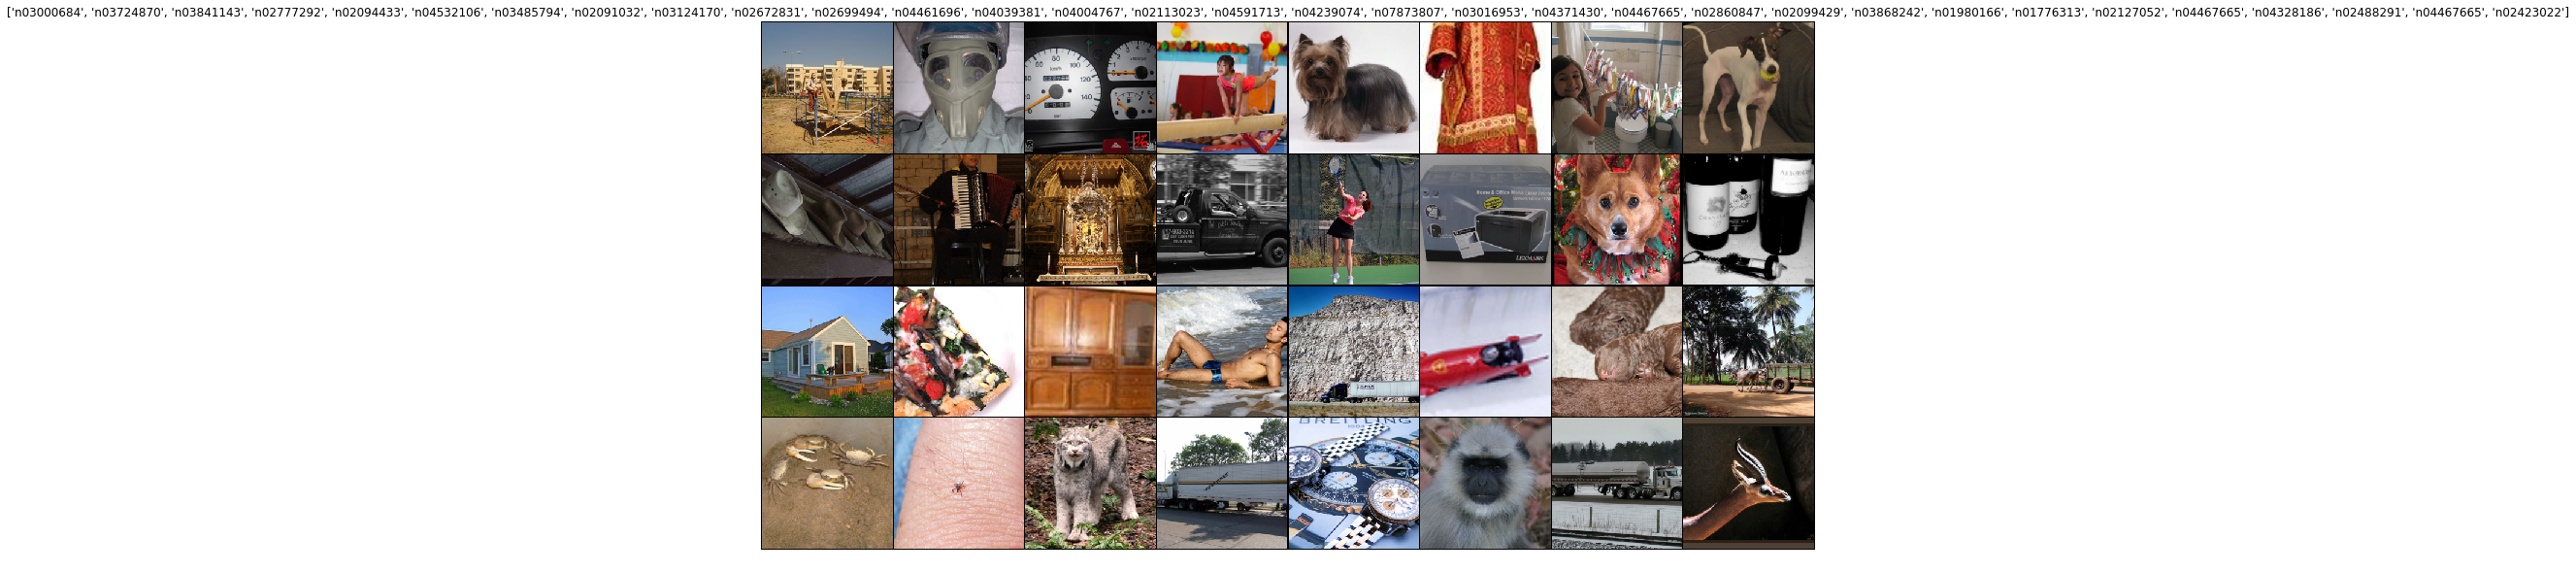

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(30, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
    
def visualize_model(vgg, num_images=6):
    
    with torch.no_grad():
        vgg.eval()
        images_so_far = 0

        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            size = inputs.size()[0]

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)
            print("labelling equality:")
            print(np.array(labels.data.cpu()) == np.array(predicted_labels))
            
            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()

            images_so_far += size
            if images_so_far >= num_images:
                break

    vgg.train() # Revert model back to original training state

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [7]:
use_gpu = torch.cuda.is_available()

def train_model(vgg, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[TEST])
    
    for epoch in range(num_epochs):
        since_batch = time.time()
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            
            if i % 1 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                loss_train += loss.data.item()
                #print(preds, labels.data)
                acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds, loss
            torch.cuda.empty_cache()
        
        elapsed_time = time.time() - since_batch
        print("\rEpoch completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train / float(dataset_sizes[TRAIN])
        avg_acc = acc_train / float(dataset_sizes[TRAIN])
        
        with torch.no_grad():
            vgg.train(False)
            vgg.eval()
            #criterion.eval()

            for i, data in enumerate(dataloaders[TEST]):
                if i % 1 == 0:
                    print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

                inputs, labels = data

                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.data.item()
                acc_val += torch.sum(preds == labels.data).item()

                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()

        avg_loss_val = loss_val / dataset_sizes[TEST]
        avg_acc_val = acc_val / dataset_sizes[TEST]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [8]:
vgg16 = models.vgg16_bn(pretrained=False).cuda()

if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

resume_training = True

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('./models/VGG16_imagenet.pt'))
    print("Loaded!")

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loading pretrained model..
Loaded!


In [9]:
#vgg16 = train_model(vgg16, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
#torch.save(vgg16.state_dict(), './models/VGG16_imagenet.pt')

Ground truth:


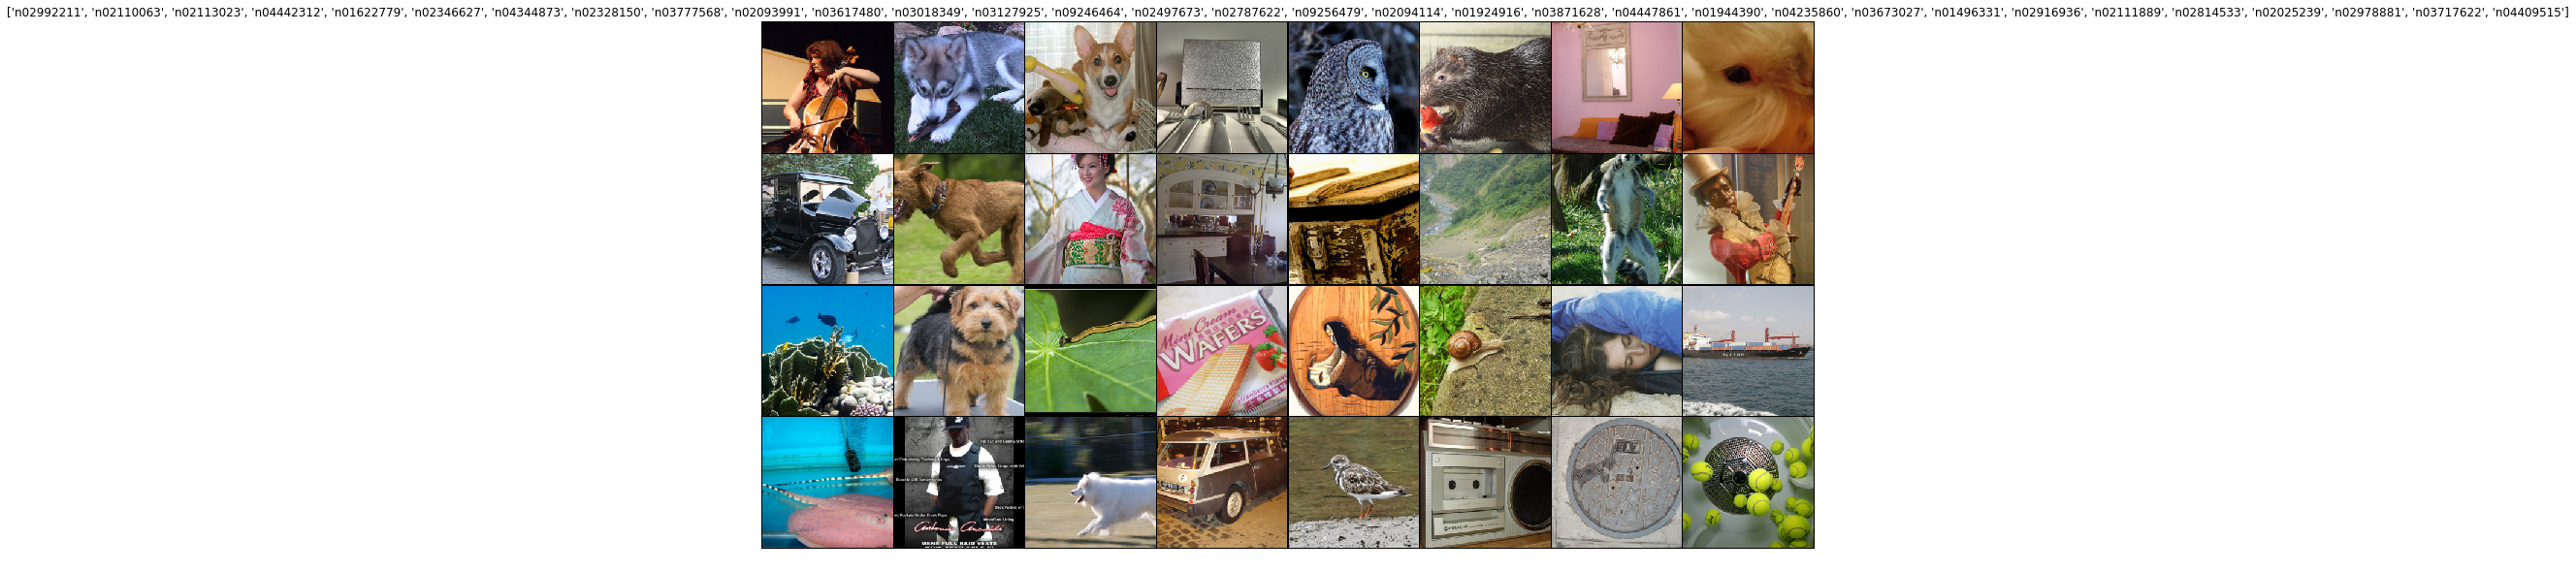

Prediction:


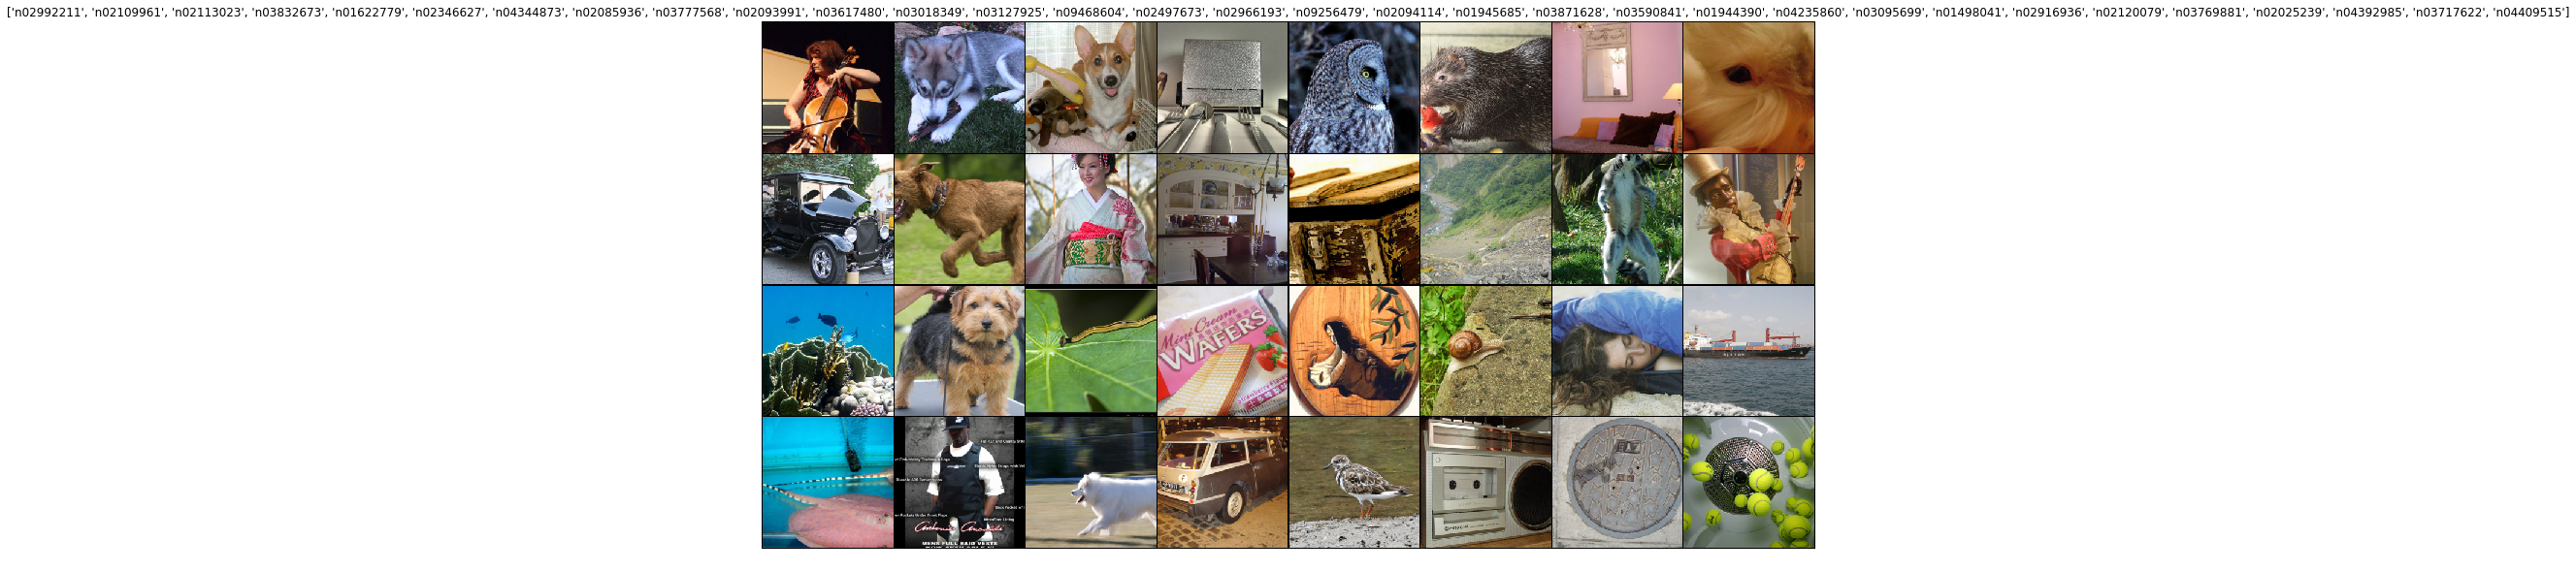

labelling equality:
[ True False  True False  True  True  True False  True  True  True  True
  True False  True False  True  True False  True False  True  True False
 False  True False False  True False  True  True]


In [10]:
visualize_model(vgg16, 8)

## Compute entropy for train and test

In [11]:
_, dataloaders, _, _ = load_imagenet(data_dir,
                           200, #batch_size
                           shuffle=True,
                           num_workers=1,
                           pin_memory=True)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


In [12]:
with torch.no_grad():
    scores_train = Tensor()
    scores_test = Tensor()

    for batch in tqdm(dataloaders[TRAIN]):
        scores_train = torch.cat((scores_train, vgg16(batch[0].cuda())), 0)
        
    for batch in tqdm(dataloaders[TEST]):
        scores_test = torch.cat((scores_test, vgg16(batch[0].cuda())), 0)

100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


In [24]:
H_train_array = scores_train.detach().cpu().numpy()
H_test_array = scores_test.detach().cpu().numpy()

In [25]:
H_softmax_train = np.apply_along_axis(lambda r : np.exp(r)/np.sum(np.exp(r)), 1, H_train_array)
H_softmax_test = np.apply_along_axis(lambda r : np.exp(r)/np.sum(np.exp(r)), 1, H_test_array)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [15]:
H_train = np.apply_along_axis(lambda r: entropy(r), 1, H_softmax_train)
H_test = np.apply_along_axis(lambda r: entropy(r), 1, H_softmax_test)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


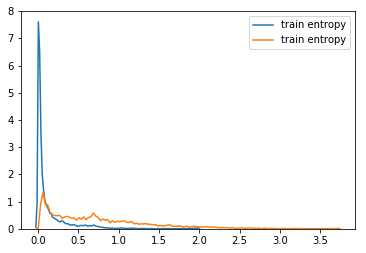

In [23]:
sns.kdeplot(H_train, bw=0.01,label='train entropy')
sns.kdeplot(H_test,  bw=0.01,label='train entropy')

### G

In [11]:
_, dataloaders, _, _ = load_imagenet(data_dir,
                           128, #batch_size
                           shuffle=True,
                           num_workers=4,
                           pin_memory=False)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


In [12]:
vgg16.eval()
train_loader, test_loader = generate_dataloader_g(vgg16, 
                                                  dataloaders[TRAIN], 
                                                  dataloaders[TEST],
                                                  [vgg16.features[40]], ['conv'])

79it [01:07,  1.16it/s]


In [13]:
import gc, sys, psutil

def memReport():
    s = 0
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            s += 1
            print('device:',obj.device, '| type:', type(obj), '| size:',obj.size())
    print(s, 'tensors objects in memory')
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()
print()
#memReport()

3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
15.0
svmem(total=16829980672, available=5720363008, percent=66.0, used=10681286656, free=1973723136, active=13753380864, inactive=340897792, buffers=51429376, cached=4123541504, shared=85688320, slab=382214144)
memory GB: 9.831035614013672



In [14]:
train_dataloader = DataLoader(train_loader, pin_memory=True, batch_size=128)
test_dataloader = DataLoader(test_loader, pin_memory=True, batch_size=128)

In [86]:
del train_loader, test_loader, dataloaders, 
del train_dataloader, test_dataloader

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [16]:
def vgg_block():
    model = nn.Sequential(
        #nn.BatchNorm2d(512),
        nn.MaxPool2d(2),
        View([-1]),
        nn.Linear(in_features=25088, out_features=4096, bias=True),
        nn.RReLU(),
        nn.Dropout(p=0.5),
        nn.BatchNorm1d(4096),
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.RReLU(),
        nn.Dropout(p=0.5),
        nn.BatchNorm1d(4096),
        nn.Linear(in_features=4096, out_features=2, bias=True),
    )
    return model

In [17]:
model = vgg_block()#denseG(512*14*14) #kindaResnetG((1,1, 512,14,14))

if use_gpu:
    model.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model = train_model(model, {TRAIN: train_dataloader, TEST: test_dataloader}, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/1
----------
Epoch completed in 0m 6s

Validation batch 47/48
Epoch 0 result: 
Avg loss (train): 0.0078
Avg acc (train): 0.6926
Avg loss (val): 0.0033
Avg acc (val): 0.3063
----------


Training completed in 0m 8s
Best acc: 0.3063


In [32]:
def visualize_model_g(vgg, dataloaders, num_images=6):
    with torch.no_grad():
        vgg.eval()
        images_so_far = 0

        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            size = inputs.size()[0]

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            inputs = (inputs - inputs.mean())/inputs.std()
            inputs = inputs[:,144:147,:,:]
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)

            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()

            images_so_far += size
            if images_so_far >= num_images:
                break

    vgg.train() # Revert model back to original training state

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth:


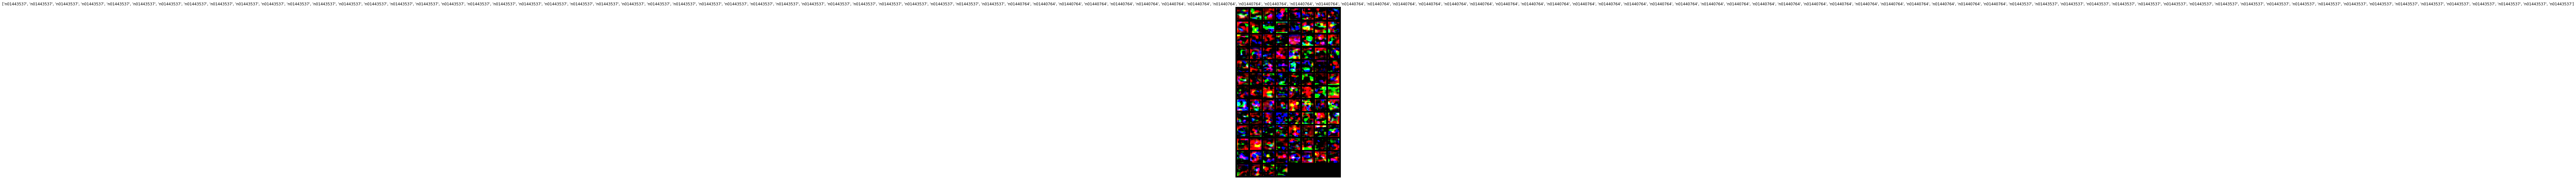

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:


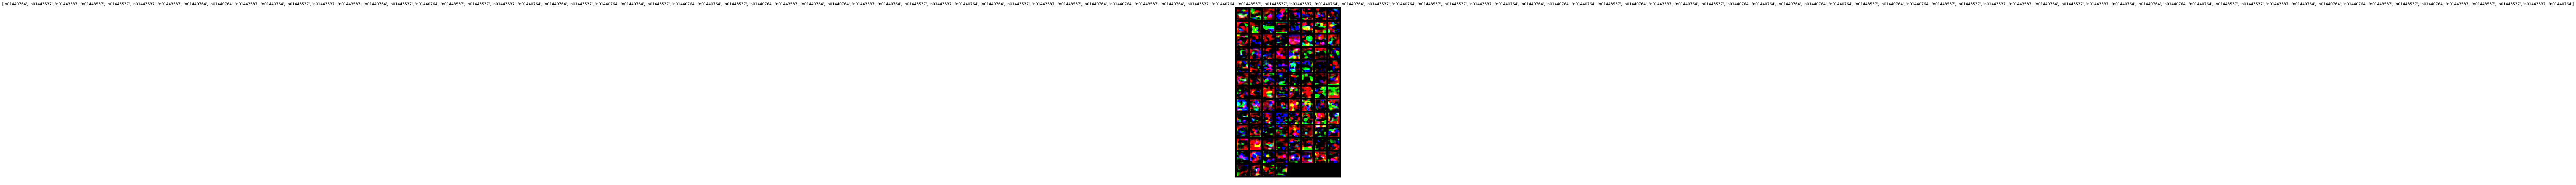

In [33]:
visualize_model_g(model, {TRAIN: train_dataloader, TEST: test_dataloader}, 8)

false negative percentage : 51.558910403675746
false positive percentage : 47.91598293403347


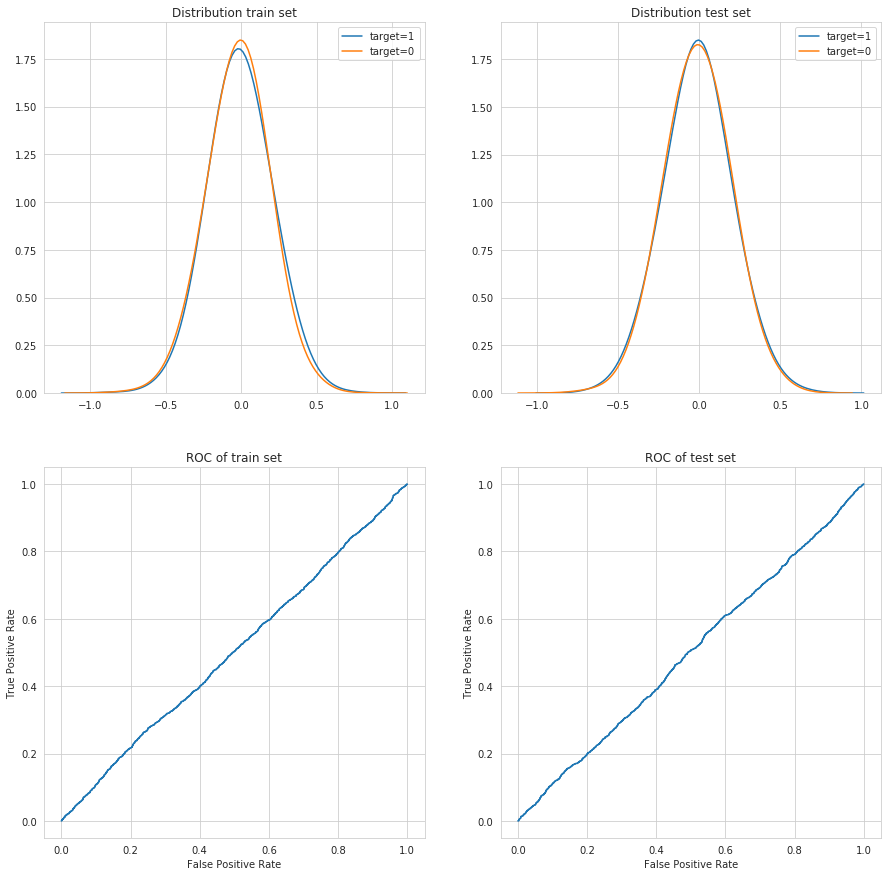

In [85]:
diagnostic_plots(model, train_dataloader, test_dataloader)